# Import Dependencies

In [99]:
import re
import pickle
import string
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy import displacy, lemmatizer

from gensim.models import word2vec

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
import seaborn as sns
import matplotlib.pyplot as plt

# Custom functions from .py files
from web_scrape import get_transcript
from preprocess import clean, preprocess

# Import/Preprocess Data

In [6]:
# Web scrape most recent speeches using our imported 'get_transcript'
goodyear = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-goodyear-az-october-28')
bullhead = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-bullhead-city-az-october-28')
omaha = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-omaha-ne-october-27')
wsalem = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-west-salem-wisconsin-october-27')
lansing = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-lansing-michigan-october-27')
martinsburg = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-martinsburg-pa-october-26')
lititz = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-lititz-pa-october-26')
allentown = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-allentown-pa-october-26')

In [7]:
# Clean all of the speeches in the corpus using our imported 'clean' function
clean_goodyear = clean(goodyear)

In [8]:
# Preprocess the speeches using our imported 'preprocess' function
processed_goodyear = preprocess(clean_goodyear)

# Document-Term Matrices

In [9]:
# Countvectorizer
cv = CountVectorizer(stop_words='english')

X_cv = cv.fit_transform(processed_goodyear)

df_cv = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())

In [10]:
# TF_IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(**cv.get_params())

X_tfidf = tfidf_vectorizer.fit_transform(processed_goodyear)

df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1795: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn("Only {} 'dtype' should be used. {} 'dtype' will "


# PCA

In [19]:
# Instantiate PCA
pca_cv = PCA(n_components=2)
pca_tfidf = PCA(n_components=2)

In [42]:
# Fit both PCAs
pca_cv_result = pca_cv.fit_transform(X_cv.toarray())
pca_tfidf_result = pca_tfidf.fit_transform(X_tfidf.toarray())

In [26]:
# Explained Variance
print(f"Count Vectorizer explained variance: {pca_cv.explained_variance_ratio_}")
print(f"TFIDF explained variance: {pca_tfidf.explained_variance_ratio_}")

# Count Vectorizer has higher explained variance for both components

Count Vectorizer explained variance: [0.02537273 0.02111927]
TFIDF explained variance: [0.02226174 0.01874518]


In [93]:
# to understand the importance of each variable in each PC, look at the correlations:
# Use Count Vectorizer due to higher explained variance
df_pca = pd.DataFrame(pca_cv.components_, index = ['PC1','PC2'], columns=cv.get_feature_names())

In [94]:
df_pca

,able,abolish,abortion,abraham,abuse,access,accomplishment,accountability,achieve,acknowledge,...,wyatt,xenophobic,year,yee,yes,yesterday,york,young,yuma,zero
PC1,-0.001415,0.001432,-0.000726,0.013835,-0.000688,0.062325,-0.000296,-0.000067,-0.000563,0.009383,...,0.000558,-0.001083,0.125333,-0.001155,0.000096,-0.002189,0.013462,0.004443,-0.001273,-0.000489
PC2,-0.000036,-0.001288,-0.000025,-0.003764,-0.000171,-0.007774,0.000073,-0.000328,-0.000003,0.000075,...,-0.000438,0.000269,-0.034538,0.000291,-0.000262,0.000545,-0.008920,-0.003999,-0.000055,-0.000285


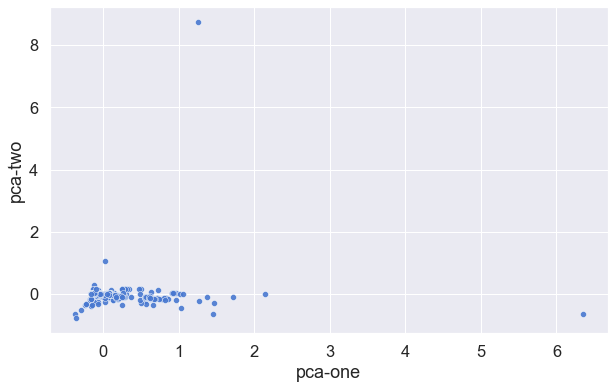

In [100]:
# Visualize
# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df_cv.shape[0])

# Create columns for seaborn plotting
df_cv['pca-one'] = pca_cv_result[:,0]
df_cv['pca-two'] = pca_cv_result[:,1] 

plt.figure(figsize=(10,6))
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=df_cv.loc[rndperm,:],
    legend="full",
    alpha=0.9
)

## Scree plot

In [30]:
pca2 = PCA(n_components=15)
pca2.fit(X_cv.toarray())
pcafeatures_train2 = pca2.transform(X_cv.toarray())

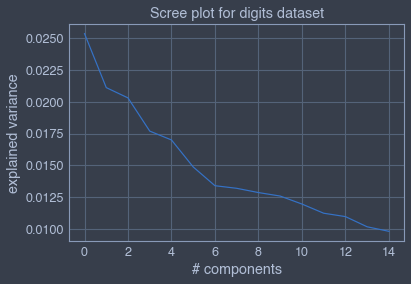

In [31]:
plt.plot(pca2.explained_variance_ratio_)
plt.xlabel('# components')
plt.ylabel('explained variance');
plt.title('Scree plot');

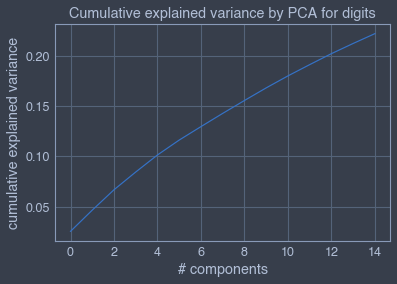

In [32]:
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('# components')
plt.ylabel('cumulative explained variance');
plt.title('Cumulative explained variance by PCA for digits');